<h2 style="text-align:center;color:blue">Lending Club Case Study</h2>
<h4 style="text-align:right;color:green">-Submitted by: Faraz and Utkarsh</h4>


#### Importing the Libraries

In [155]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Dataframe

In [156]:
#load data in dataframe
loan_master = pd.read_csv('loan.csv',low_memory=False)

In [157]:
#check number of rows and columns
loan_master.shape

(39717, 111)

In [158]:
loan_master.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   term                            39717 non-null  object 
 6   int_rate                        39717 non-null  object 
 7   installment                     39717 non-null  float64
 8   grade                           39717 non-null  object 
 9   sub_grade                       39717 non-null  object 
 10  emp_title                       37258 non-null  object 
 11  emp_length                      38642 non-null  object 
 12  home_ownership                 

### Data Cleaning - Starts Here

#### User Defined Functions for Data Cleaning

In [159]:
#function to check for nulls and only display the columns having null count>0
def check_null(dataframe, percentage=True):
    if percentage==True:
        return round(dataframe.isnull().mean()[dataframe.isnull().mean()>0].apply(lambda x: x*100),3)
    else:
        return dataframe.isnull().sum()[dataframe.isnull().sum()>0]
    
#function to drop irrelevant columns
def drop_irrelevant_columns(dataframe, column_list):
    dataframe.drop(column_list, axis=1, inplace=True, errors='ignore')
    
#function to drop columns based on NULLs percentage
def dropna_cols_perc(dataframe, percentage):
    n_thresh = int(len(loan_master)*(1-(percentage/100)))
    dataframe.dropna(axis=1, thresh=n_thresh, inplace=True)

#function to drop rows of columns with insignificant nulls
def drop_insignificant_rows(df,col_subset_list):
    df.dropna(subset=col_subset_list, inplace=True)

#function to print column details
#looping?
def tell_about_columns(df, *col_names):
    for data in col_names:
        print(f"Column name: {data} {'*'*5} Nunique: {df[data].nunique()}, Dtype: {df[data].dtype}, Null Count: {df[data].isna().sum()}")

#Print mean and median in one line for easier lookup
def get_mean_median(data):
    return f"Mean is: {data.mean()}, Median is: {data.median()}"

#### Data Cleaning - Handle Nulls

In [160]:
#check columns having nulls
check_null(loan_master)

emp_title                       6.191
emp_length                      2.707
desc                           32.581
title                           0.028
mths_since_last_delinq         64.662
                               ...   
tax_liens                       0.098
tot_hi_cred_lim               100.000
total_bal_ex_mort             100.000
total_bc_limit                100.000
total_il_high_credit_limit    100.000
Length: 68, dtype: float64

In [161]:
# Dropping the columns having all null values
loan_master.dropna(axis=1, how='all', inplace=True)
#check shape again
loan_master.shape

(39717, 57)

##### Above we saw that we are left with 57 columns now after removing the columns where all values are null. Let us clean further

In [162]:
#check again for columns having nulls
check_null(loan_master)

emp_title                      6.191
emp_length                     2.707
desc                          32.581
title                          0.028
mths_since_last_delinq        64.662
mths_since_last_record        92.985
revol_util                     0.126
last_pymnt_d                   0.179
next_pymnt_d                  97.130
last_credit_pull_d             0.005
collections_12_mths_ex_med     0.141
chargeoff_within_12_mths       0.141
pub_rec_bankruptcies           1.755
tax_liens                      0.098
dtype: float64

In [163]:
# Dropping the columns where null precentage is more than 60% as it will not help in any conclusion
dropna_cols_perc(loan_master,60)

#Checking the shape again
loan_master.shape

(39717, 54)

In [164]:
#check again for columns having nulls
check_null(loan_master)

emp_title                      6.191
emp_length                     2.707
desc                          32.581
title                          0.028
revol_util                     0.126
last_pymnt_d                   0.179
last_credit_pull_d             0.005
collections_12_mths_ex_med     0.141
chargeoff_within_12_mths       0.141
pub_rec_bankruptcies           1.755
tax_liens                      0.098
dtype: float64

#### Checking and dropping any irrelevent columns

There are a few columns having a single unique value or all unique values. These may have nothing much to contribute to the analysis i.e. columns which are far from being the driving columns towards loan default. Some other columns are redundant.
<br>
These columns are:
1. **id** - loan identification number, does not contribute to analysis. Verified to be unique.
2. **member_id** - member identification number, does not contribute to analysis. Verified to be unique.
3. **desc** - It is description added by users. NOt useful now as it is textual data.
4. **zip_code** - first 3 digits of the 5 digit zip code are visible, also is redundant with addr_state, does not contribute to analysis
5. **url** - is a URL for LC page for corresponding to each memberid, nothing to do with loan default.
6. **acc_now_delinq** - All values are 0, therefore can be removed.
7. **title** - Large number of values which is unclassified, used purpose instead.
8. **application_type** - All values are INDIVIDUAL, will not be useful for analysis.
9. **chargeoff_within_12_mths** - All values are either 0 of null, will not be useful
10. **collections_12_mths_ex_med** - All values are either 0 or null, will not be useful.
11. **delinq_amnt** - All values are 0, therefore can be removed.
12. **initial_list_status** - value for entire dataset is 'f' out of the possible values, therefore can be removed.
13. **policy_code** - All values are 1, indicating all are publicly available, therefore nothing to contribute for analysis, to be removed.
14. **tax_liens** - All values are either 0 or 1, so can be removed.

In [165]:
#list columns that are determined to be irrelevant to our analysis
list_irrelevant_cols=[]
list_irrelevant_cols.append('member_id') #Unique ID, will not be insightful. We have id column to measure uniqueness.
list_irrelevant_cols.append('desc') #text entered by borrower 
list_irrelevant_cols.append('zip_code') #first 3 chars only followed by xx
list_irrelevant_cols.append('url') #loan id already available
list_irrelevant_cols.append('acc_now_delinq') #only having 0s/Nas
list_irrelevant_cols.append('title') #use purpose instead
list_irrelevant_cols.append('application_type') #all loans are individual
list_irrelevant_cols.append('chargeoff_within_12_mths') #only having 0s/Nas
list_irrelevant_cols.append('collections_12_mths_ex_med') #only having 0s/Nas
list_irrelevant_cols.append('delinq_amnt') #only having 0s/Nas
list_irrelevant_cols.append('initial_list_status') #only having value f
list_irrelevant_cols.append('policy_code') #only having value 1
list_irrelevant_cols.append('tax_liens') #only having 0s/Nas

In [166]:
# Dropping the irrelevent columns
drop_irrelevant_columns(loan_master,list_irrelevant_cols)

#Checking shape after removing irrelevent columns
loan_master.shape

(39717, 41)

In [167]:
#check again for columns having nulls
check_null(loan_master)

emp_title               6.191
emp_length              2.707
revol_util              0.126
last_pymnt_d            0.179
last_credit_pull_d      0.005
pub_rec_bankruptcies    1.755
dtype: float64

##### Let us analyse the above columns and treat them accordingly.

In [168]:
tell_about_columns(loan_master, 'emp_title','emp_length')

Column name: emp_title ***** Nunique: 28820, Dtype: object, Null Count: 2459
Column name: emp_length ***** Nunique: 11, Dtype: object, Null Count: 1075


In [169]:
# As the dtype is object and the null count is insignificant, instead of imputing better we choose to drop it to avoid any biasness.
# Dropping the rows where these columns values are null
drop_insignificant_rows(loan_master,['emp_title','emp_length'])

In [170]:
#Let us analyse the columns with very less null counts
tell_about_columns(loan_master, 'revol_util','last_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies')

Column name: revol_util ***** Nunique: 1082, Dtype: object, Null Count: 46
Column name: last_pymnt_d ***** Nunique: 101, Dtype: object, Null Count: 64
Column name: last_credit_pull_d ***** Nunique: 106, Dtype: object, Null Count: 0
Column name: pub_rec_bankruptcies ***** Nunique: 3, Dtype: float64, Null Count: 654


In [171]:
# Treating pub_rec_bankruptcies 
loan_master['pub_rec_bankruptcies'].value_counts()

0.0    35039
1.0     1502
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

##### pub_rec_bankruptcies has either value 0 or 1 or 2, we can replace then with mode but we decided to drop it to avoid any introduced biasness and for last_pymnt_d it is of date type column so unable to impute it properly and dropping it finally

In [172]:
drop_insignificant_rows(loan_master,['pub_rec_bankruptcies','last_pymnt_d'])

##### Let us treat revol_util by trying to impute it with suitable value

In [173]:
loan_master['revol_util'] = loan_master['revol_util'].str.replace('%','').str.strip().astype(float)

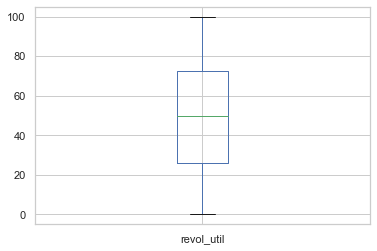

In [174]:
loan_master['revol_util'].plot(kind='box')
plt.show()

In [175]:
# Checking mean of revol_util before imputation
get_mean_median(loan_master['revol_util'])

'Mean is: 49.276383568409855, Median is: 49.9'

In [176]:
loan_master['revol_util'] = loan_master['revol_util'].fillna(loan_master['revol_util'].mean())

In [177]:
# Checking mean of revol_util after imputation
get_mean_median(loan_master['revol_util'])

'Mean is: 49.27638356840974, Median is: 49.8'

##### We can see that after imputation mean and median is almost same as before imputation, so we are moving forward with this.

In [178]:
#check again, columns having nulls
check_null(loan_master,percentage=False)

Series([], dtype: int64)

In [179]:
# Checking shape of remaining data set
loan_master.shape

(36484, 41)

##### We have handled all the Nulls present in the data. Let us move forward

#### Data Cleaning - Handle Data Types

In [180]:
#fix data type for 'term' as int
loan_master['term'] = loan_master['term'].str.replace('months','').str.strip().astype(int)
#loan_master = loan_master.rename(columns={'term':'term_months'})

In [181]:
#fix data type for 'int_rate' as 'float' 
loan_master['int_rate'] = loan_master['int_rate'].str.strip('%').astype(float)

In [182]:
#fix data type emp_length
loan_master['emp_length'].value_counts()

10+ years    8409
2 years      4183
< 1 year     4063
3 years      3918
4 years      3305
5 years      3135
1 year       3031
6 years      2125
7 years      1700
8 years      1407
9 years      1208
Name: emp_length, dtype: int64

In [183]:
emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

In [184]:
loan_master = loan_master.replace({'emp_length': emp_length_dict })

#### Treating and analyzing datetime columns

In [185]:
#Converting the datetime cols into datetime datatype
loan_master[['issue_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line']] = \
loan_master[['issue_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line']].apply(pd.to_datetime,format='%b-%y') 

In [186]:
loan_master[['issue_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line']]

,issue_d,last_credit_pull_d,last_pymnt_d,earliest_cr_line
1,2011-12-01,2013-09-01,2013-04-01,1999-04-01
3,2011-12-01,2016-04-01,2015-01-01,1996-02-01
4,2011-12-01,2016-05-01,2016-05-01,1996-01-01
5,2011-12-01,2016-01-01,2015-01-01,2004-11-01
6,2011-12-01,2016-05-01,2016-05-01,2005-07-01
...,...,...,...,...
39551,2007-12-01,2014-05-01,2010-02-01,2000-12-01
39562,2007-11-01,2008-08-01,2008-08-01,2000-03-01
39623,2007-10-01,2016-05-01,2008-05-01,1997-08-01
39666,2007-08-01,2010-03-01,2009-10-01,1992-11-01


##### Datetime - sanity checks

In [187]:
# Checking the validity as it is mentioned that Issue date lies between 2007 to 2011
print('Invalid rows in issue_d:',loan_master[(loan_master['issue_d'] > '2011-12-31') | (loan_master['issue_d'] < '2007-01-01')].shape[0])

Invalid rows in issue_d: 0


In [188]:
# Checking for invalid future rows
date_today = pd.to_datetime('today')
print('Invalid future rows in last_credit_pull_d:',loan_master[(loan_master['last_credit_pull_d'] > date_today)].shape[0])
print('Invalid future rows in last_pymnt_d:',loan_master[(loan_master['last_pymnt_d'] > date_today)].shape[0])
print('Invalid future rows in earliest_cr_line:',loan_master[(loan_master['earliest_cr_line'] > date_today)].shape[0])

Invalid future rows in last_credit_pull_d: 0
Invalid future rows in last_pymnt_d: 0
Invalid future rows in earliest_cr_line: 50


##### earliest_cr_line is having some invalid future rows due to datetime conversion - fixing them

In [189]:
#determine cut off year for earliest_cr_line
print('cut off based on last credit pull', loan_master['last_credit_pull_d'].dt.year.max())

cut off based on last credit pull 2016


In [190]:
#fix earliest_cr_line to change century (year-100) for all rows > 2016
loan_master['earliest_cr_line'] = loan_master['earliest_cr_line'].apply(lambda x: x if x.year<=2016 else date(x.year-100,x.month,x.day))

In [191]:
#recheck invalid future rows
print('Invalid future rows in earliest_cr_line:',loan_master[(loan_master['earliest_cr_line'] > date_today)].shape[0])

Invalid future rows in earliest_cr_line: 0


#### Derived Metrics

In [192]:
#derive year from all date columns - for easier analysis later 
loan_master['earliest_cr_line_year'] = loan_master['earliest_cr_line'].dt.year
loan_master['last_credit_pull_year'] = loan_master['last_credit_pull_d'].dt.year
loan_master['last_pymnt_year'] = loan_master['last_pymnt_d'].dt.year
loan_master['issue_year'] = loan_master['issue_d'].dt.year

### Data Cleaning - Ends Here

### Analysis

##### User defined functions for plotting

In [193]:
#annotate function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
#and modified as per needs
sns.set(style='whitegrid')
def annotate_bar(ax,percent=False): 
    """Add labels to the end of each bar in a bar chart.
       Function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
       ----------Edited as per requirement----------
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 2
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if percent:
            label = "{:.1f}%".format(y_value)
        else:
            label = "{:.1f}".format(y_value)
            

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize=10,                # Set font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [194]:
def comparison_plot_old(df,col_name,pick_top=0,palette_name = 'husl'):
    d1 = df[df['loan_status']=='Charged Off'][col_name].value_counts(normalize=True)*100
    d1 = d1.reset_index()
    d1['Loan Status']='Charged Off'
    
    d2 = df[df['loan_status'] == 'Fully Paid'][col_name].value_counts(normalize=True)*100
    d2 = d2.reset_index()
    d2['Loan Status']='Fully Paid'
    
    if pick_top !=0:
        d1 = d1.head(pick_top)
        d2 = d2.head(pick_top)
    
    final_df = d2.append(d1)
    
    plt.figure(figsize=(18,5))
    ax1 = sns.barplot(x='index', y=col_name, data=final_df,palette=palette_name,ci=False,hue='Loan Status')
    plt.title(f'Percentage of {col_name} values',{'color' :'blue','fontsize':14})
    plt.xlabel(f'Different values for {col_name}')
    plt.ylabel(f'Percentage value')
    annotate_bar(ax1,percent=True)
    plt.show()

In [228]:
#plot segmented comparison for a column on charge off vs fully paid loans
def comparison_plot(dataframe, col_name, vertical=True, palette_name = 'husl'):
    d1 = pd.pivot_table(dataframe, index=['loan_status',col_name], values='id', aggfunc='count').reset_index()  
    d2 = pd.pivot_table(dataframe, index=[col_name], values='id', aggfunc='count').reset_index()
    d = d2.merge(d1, on=col_name)
    #derived percentage values
    d['perc']=(d['id_y']/d['id_x'])*100
    
    if vertical:
        plt.figure(figsize=(15,5))
        ax1 = sns.barplot(x=col_name, y='perc', data=d,palette=palette_name,ci=False,hue='loan_status')
        plt.xlabel(f'Different values for {col_name}')
        plt.ylabel(f'Percentage value')
        annotate_bar(ax1,percent=True)
    else:
        plt.figure(figsize=(10,10))
        ax1 = sns.barplot(x='perc', y=col_name, data=d,palette=palette_name,ci=False,hue='loan_status')
        plt.ylabel(f'Different values for {col_name}')
        plt.xlabel(f'Percentage value')
    
    plt.title(f'Percentage of {col_name} values',{'color' :'black','fontsize':14})
    plt.show()

In [196]:
#remove future warnings for distplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Univariate and segmented univariate analysis - Loan Attributes

In [197]:
#filter loan master to only have charged off and fully paid loans
#current loans are not required for our analysis
loan_master_fp_co = loan_master[loan_master['loan_status']!='Current']

**Column name: funded_amnt,funded_amnt_inv,loan_amnt** <br/>
Comparing their distribution below tells us that they are co-related. 
So, choosing funded_amnt only for further analysis

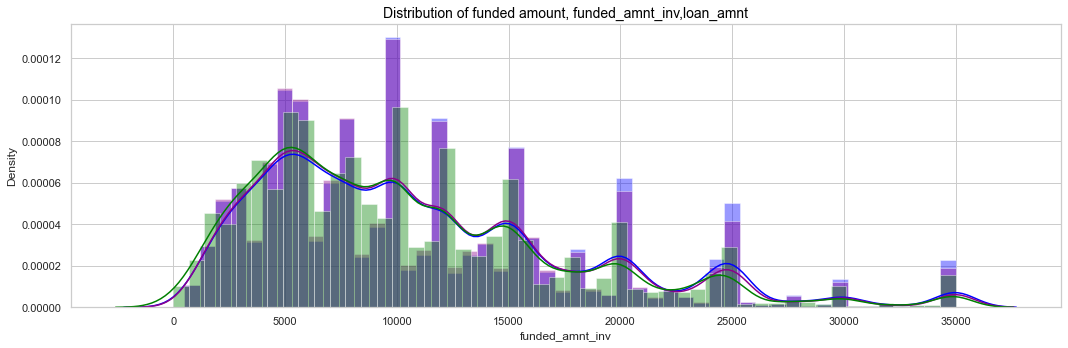

In [198]:
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
sns.distplot(loan_master_fp_co['loan_amnt'],bins=50,color='blue')
sns.distplot(loan_master_fp_co['funded_amnt'],bins=50,color='darkmagenta')
sns.distplot(loan_master_fp_co['funded_amnt_inv'],bins=50,color='green')
plt.title('Distribution of funded amount, funded_amnt_inv,loan_amnt',{'color' :'black','fontsize':14})

plt.tight_layout()
plt.show()

**Column name: loan_amnt** <br>
The listed amount of the loan applied for by the borrower.<br>

**Observation** <br>
Most of the people has taken loan amount below 15000 and few towards 25000. Above 2500 amount very few people has taken loan

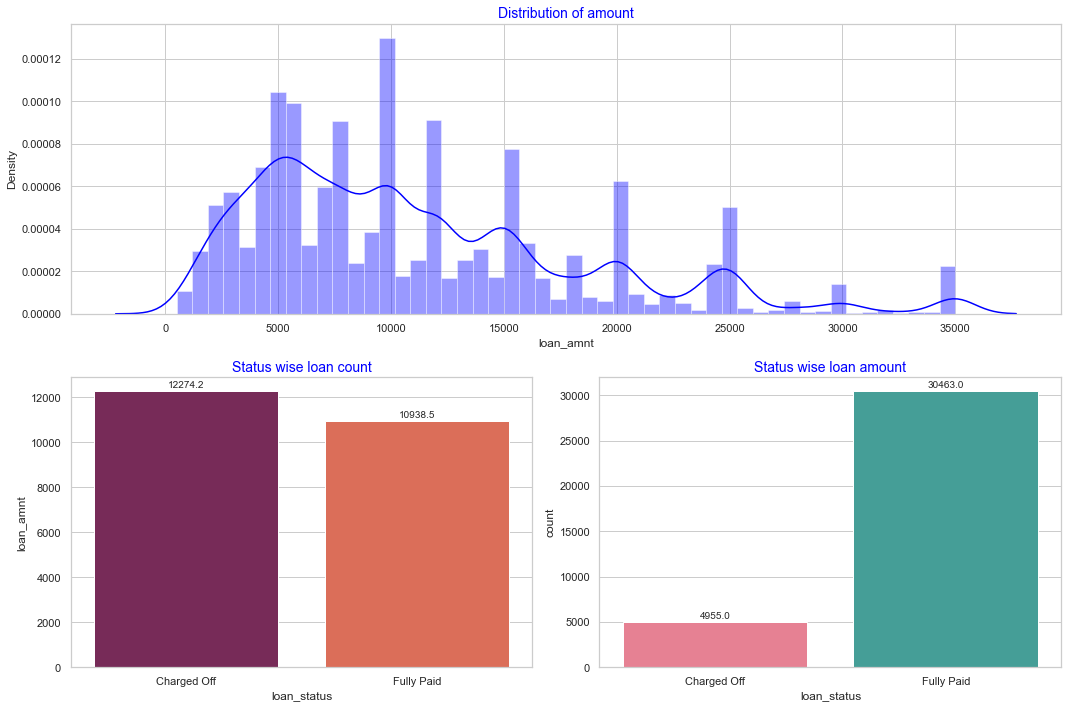

In [199]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.distplot(loan_master_fp_co['loan_amnt'],bins=50,color='blue')
plt.title('Distribution of amount',{'color' :'blue','fontsize':14})

plt.subplot(2,2,3)
ax2 = sns.barplot(x='loan_status',y ='loan_amnt', data=loan_master_fp_co,palette='rocket',ci=False)
annotate_bar(ax2)
plt.title('Status wise loan count',{'color' :'blue','fontsize':14})

plt.subplot(2, 2, 4)
ax1 = sns.countplot(x='loan_status',data=loan_master_fp_co,palette='husl')
annotate_bar(ax1)
plt.title('Status wise loan amount',{'color' :'blue','fontsize':14})

plt.tight_layout()
plt.show()

**Column name: int_rate** <br>
Interest Rate on the loan<br>

**Observation** <br>
Most of the loans have interest rate less than 15

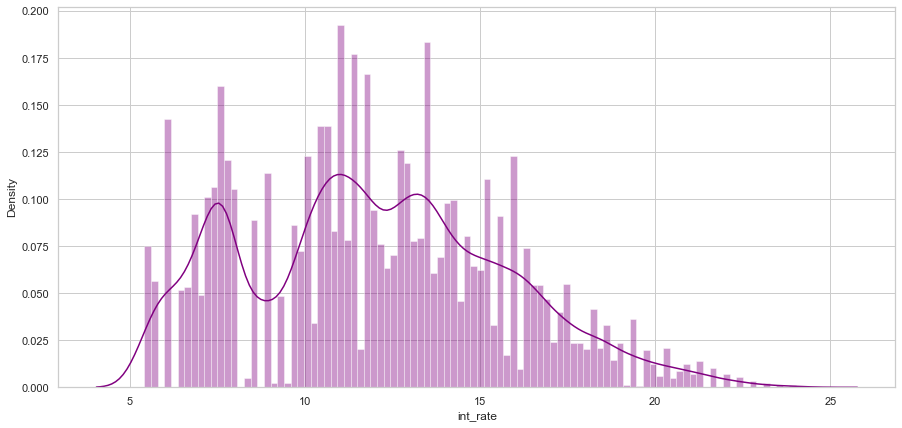

In [231]:
plt.figure(figsize=(15,7))
sns.distplot(loan_master_fp_co['int_rate'],bins=100,color='purple')
plt.show()

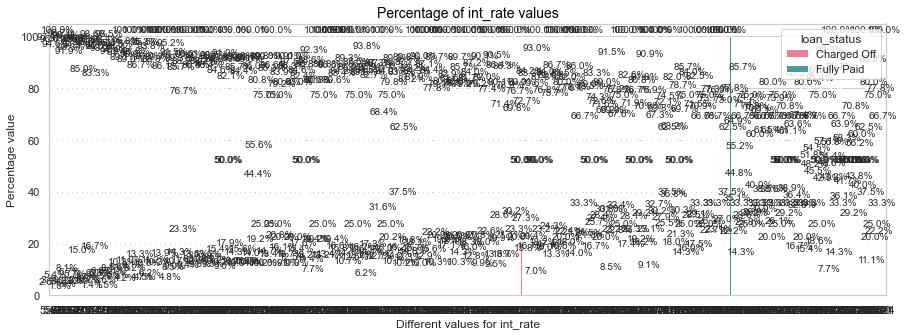

In [230]:
comparison_plot(loan_master_fp_co, 'int_rate') # need brackets

**Column name: installment <br>**
The monthly payment owed by the borrower if the loan originates.<br>

**Observation** <br>
Most of the people pay less than $400 in installments 

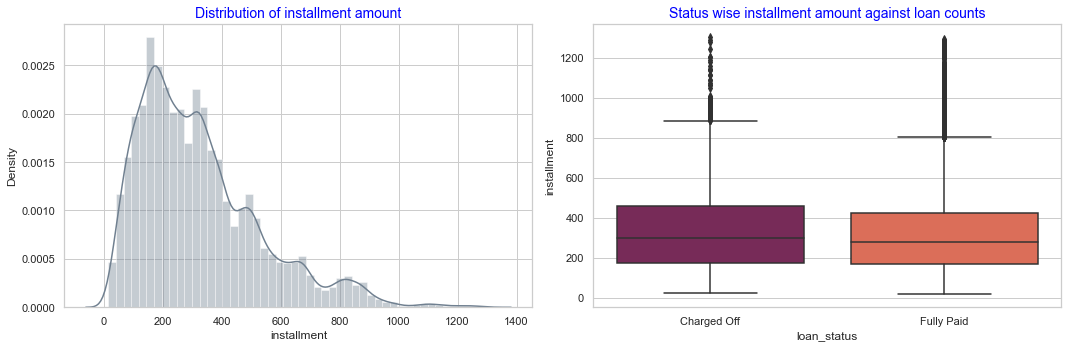

In [202]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax2 = sns.distplot(loan_master_fp_co['installment'],color='slategrey')
plt.title('Distribution of installment amount',{'color' :'blue','fontsize':14})

plt.subplot(1,2,2)
ax1 = sns.boxplot(x='loan_status',y='installment', data=loan_master_fp_co,palette='rocket')
plt.title('Status wise installment amount against loan counts',{'color' :'blue','fontsize':14})

plt.tight_layout()
plt.show()

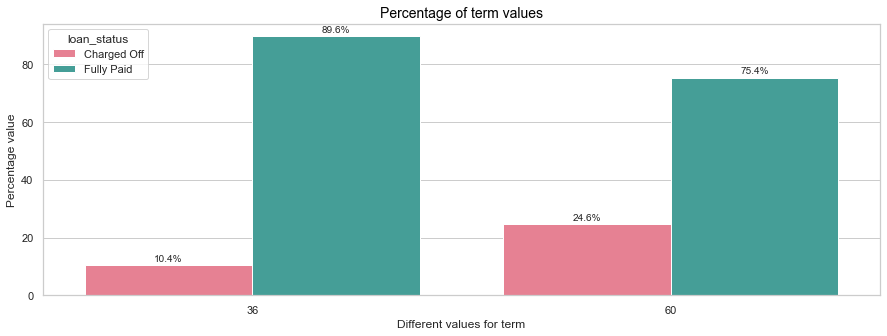

In [129]:
#Segmented Analysis
comparison_plot(loan_master_fp_co, 'term')
#This says that 60 months term is having higher chances of defaulting

**Column name: grade** <br>
LC assigned loan grade<br>

**Observation** <br>
There are high chances of defaulting if loan is Grade D or below.

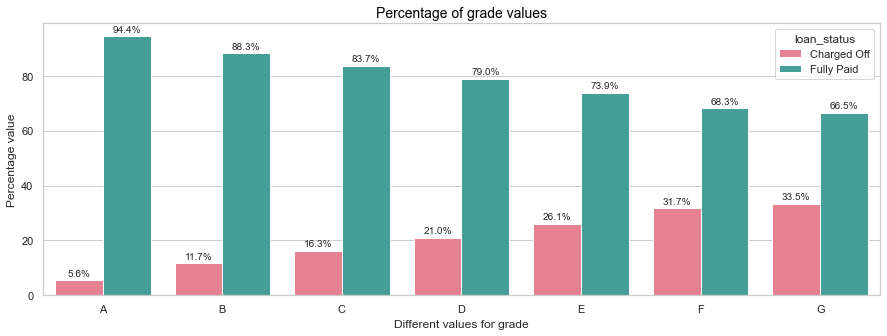

In [203]:
comparison_plot(loan_master_fp_co, 'grade')

**Column name: purpose** <br>
Purpose of loan<br>

**Observation** <br>
Loan Purpose 'small business' will have high chances of defaulting>=25%

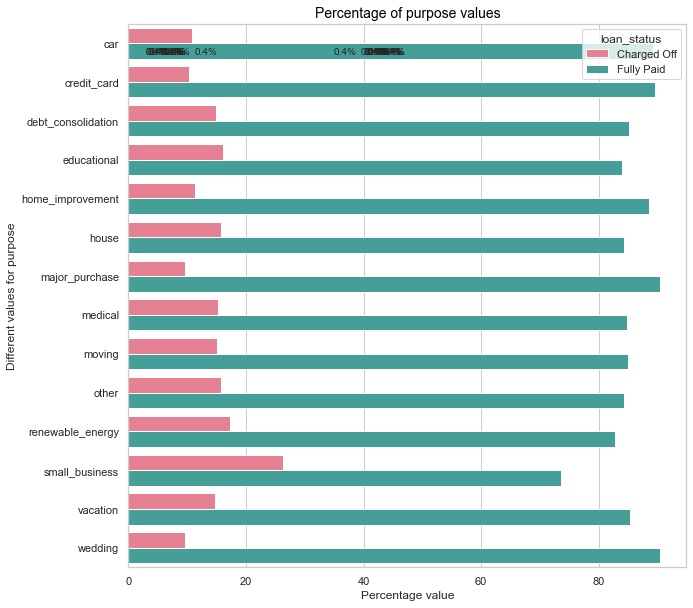

In [226]:
comparison_plot(loan_master_fp_co, 'purpose',False)

**Column name: earliest_cr_line_year** <br>
Earliest reported Credit line

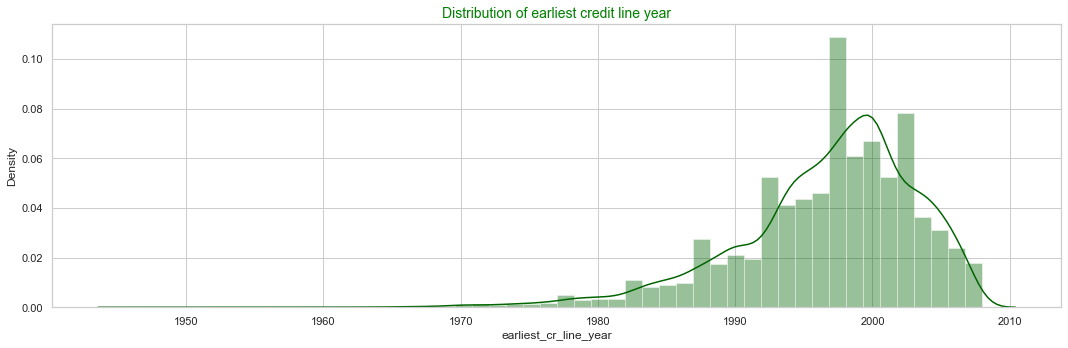

In [49]:
plt.figure(figsize=(15,5))
ax2 = sns.distplot(loan_master['earliest_cr_line_year'],bins=50,color='darkgreen')
plt.title('Distribution of earliest credit line year',{'color' :'green','fontsize':14})
plt.tight_layout()
plt.show()

##### Since we removed future year from earliest credit line years, the graphs shows that the distribution is among valid years with most credit lines from year 1995-2005

##### We can conclude that most customers had 3 or less credit inquires in last 6 months. Also, there is a notable increase in mean of inquires for customers who defaulted the loan

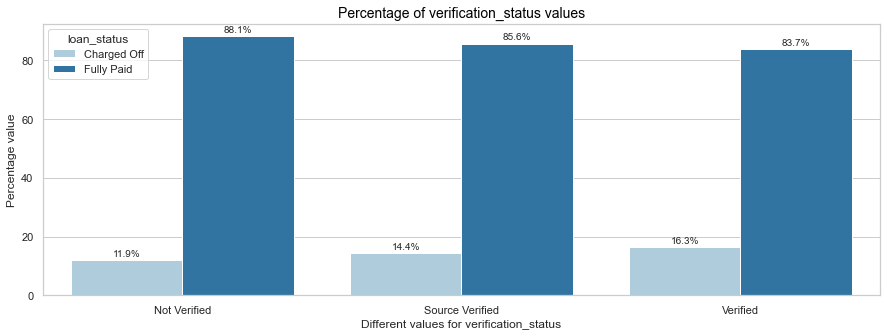

In [116]:
#Segmented Analysis
comparison_plot(loan_master_fp_co, 'verification_status')
# Verification is importatnt to do, but even after verification people are defaulting more than not
#So NO IMPACT

In [61]:
loan_master['open_acc'].value_counts()

7     3682
8     3623
6     3618
9     3447
10    2984
5     2883
11    2565
12    2125
4     2084
13    1766
14    1384
3     1325
15    1101
16     877
17     683
18     505
2      499
19     372
20     270
21     231
22     134
23      87
24      69
25      51
26      29
28      23
27      20
30      13
29      12
34       5
31       5
33       3
32       3
36       2
35       1
38       1
39       1
44       1
Name: open_acc, dtype: int64

### Univariate and segmented univariate analysis - Customer Attributes

In [47]:
top10_emp = pd.DataFrame(loan_master['emp_title'].value_counts()[:10])

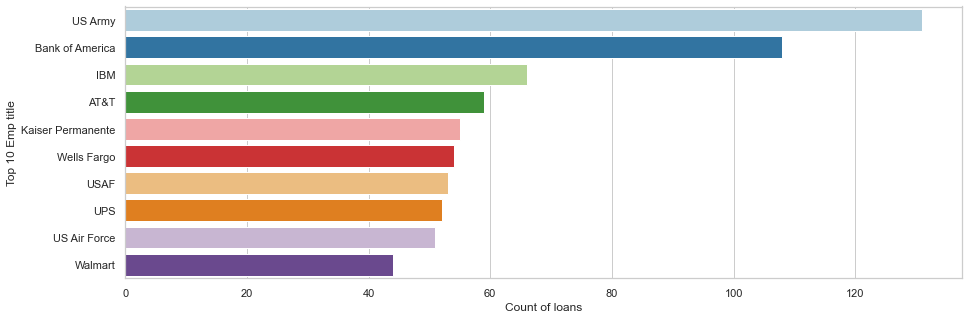

In [48]:
plt.figure(figsize=(15,5))
sns.barplot(y=top10_emp.index, x= 'emp_title',data=top10_emp,palette='Paired',ci=None)
plt.xlabel('Count of loans')
plt.ylabel('Top 10 Emp title')
plt.show()

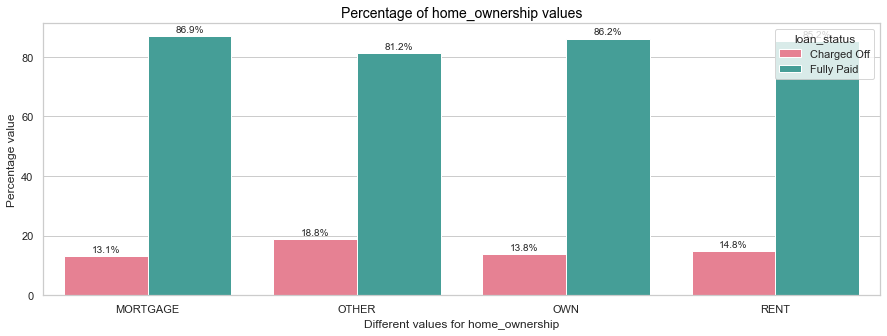

In [130]:
#Segmented Analysis
comparison_plot(loan_master_fp_co, 'home_ownership')
# People who defind other in home ownership tend to default a little more

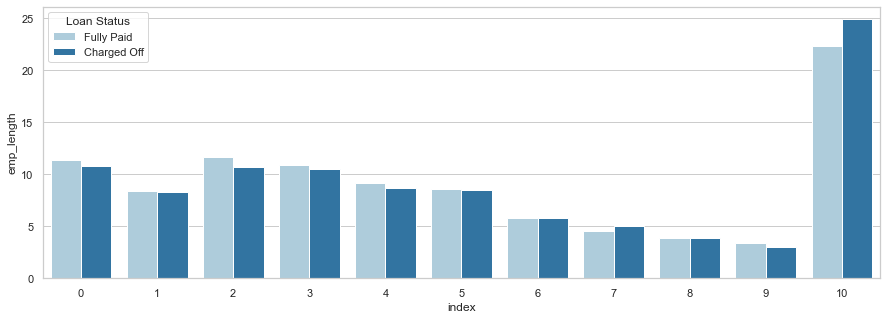

In [57]:
#Segmented Analysis
col_name ='emp_length'
comparison_plot(charged_off, fully_paid, col_name)
#We can see CA, FL, GA and NV are high risk states

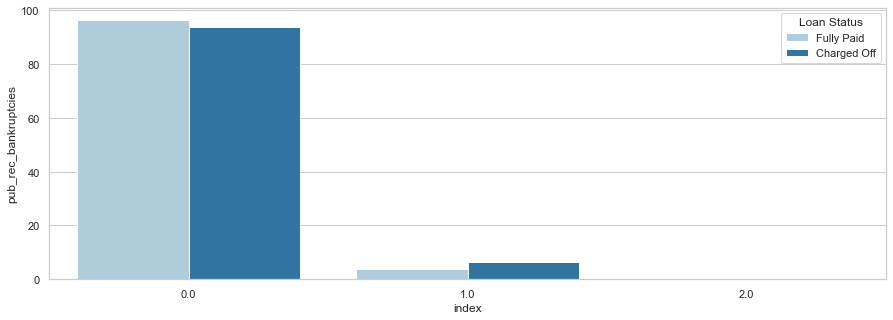

In [58]:
#Segmented Analysis
col_name ='pub_rec_bankruptcies'
comparison_plot(charged_off, fully_paid, col_name)
#If there is a bankruptcy record, there are higher chances of defaulting

In [ ]:
#Segmented Analysis
col_name ='addr_state'
comparison_plot(charged_off, fully_paid, col_name)
#We can see CA, FL, GA and NV are high risk states

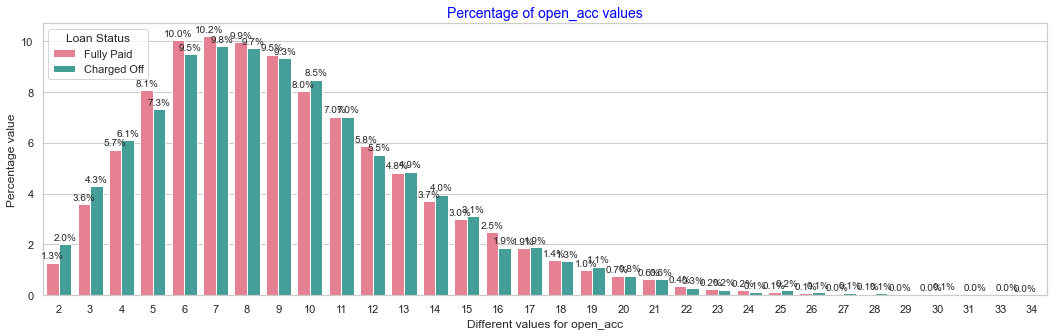

In [144]:
#Segmented Analysis
comparison_plot_old(loan_master_fp_co, 'open_acc', 30)
# we can clearly see that if user hold 10 or m ore accounts, the chances of defaulting goes up

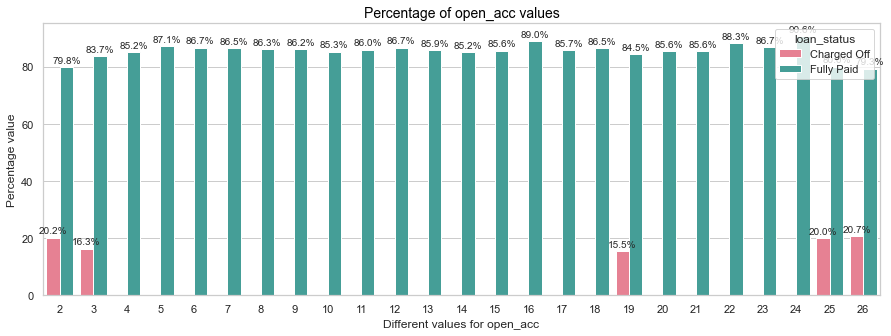

In [134]:
comparison_plot(loan_master_fp_co, 'open_acc', 30)

**Column name: inq_last_6mths** <br>
Number of inquiry in last 6 months

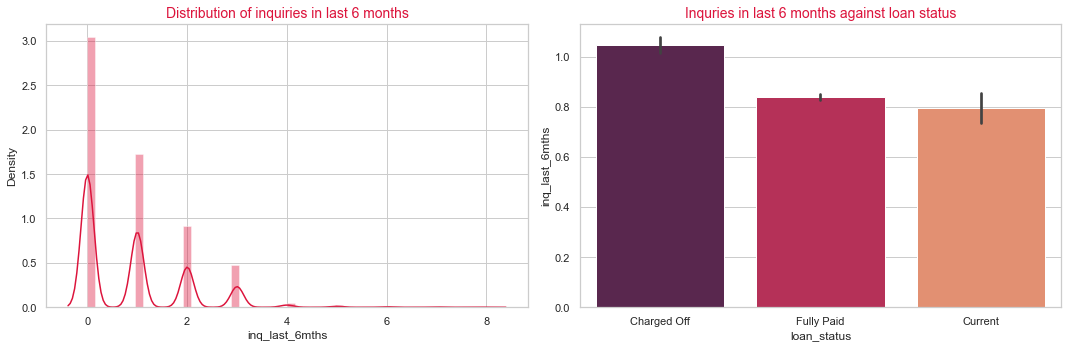

In [50]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax2 = sns.distplot(loan_master['inq_last_6mths'],color='crimson')
plt.title('Distribution of inquiries in last 6 months',{'color' :'crimson','fontsize':14})

plt.subplot(1,2,2)
sns.barplot(x="loan_status", y="inq_last_6mths", data=loan_master, palette="rocket")
plt.title('Inquries in last 6 months against loan status',{'color' :'crimson','fontsize':14})

plt.tight_layout()
plt.show()